### Import the Libraries

In [100]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

### HOG Feature Extraction

In [101]:
def get_img(image_directory, rotated= False, edge= False):
    img= cv2.imread(image_directory, cv2.IMREAD_GRAYSCALE)

    if rotated == True:
        img= cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

    if edge== True:
        img= cv2.Canny(img, 100, 200)
    
    return img
    
def get_feature_vector(image, grid_q= 4, no_orientation= 8):
    if type(grid_q)== np.ndarray: # ndarray path
        hog_features= []
        for gq in grid_q:
            hf= get_feature_vector(image, grid_q= gq, no_orientation= no_orientation)
            hog_features= np.append(hog_features, hf)
    else: # integer path
        ppc= (int(image.shape[0]/grid_q), int(image.shape[1]/grid_q))
        hog_features= hog(image, orientations= no_orientation, pixels_per_cell= (int(image.shape[0]/grid_q), int(image.shape[1]/grid_q)),
                        cells_per_block=(1, 1), feature_vector= True)

    return hog_features

# GRIDQ= 4
GRIDQ= np.arange(1, 6)
ORIENTATION= 8

In [102]:
feature_matrix= []
img_directories= []

file_list= os.listdir("./pictures/")
for i in range(1, 1500):
    img_name= str(i) + ".png"
    img_dir= "./pictures/" + str(i) + ".png"
    if img_name in file_list:
        img= get_img(img_dir)
        feature_vec= get_feature_vector(img, grid_q= GRIDQ, no_orientation= ORIENTATION)
        feature_matrix.append(feature_vec)
        img_directories.append(img_dir)

feature_matrix= np.array(feature_matrix)
img_directories= np.array(img_directories)

with open("./pictures/labels.csv") as f:
    l= f.read()
    try: # Mac
        int(l[1:2])
        l= l[1:]
    except: # Windows
        l= l[3:]
    
    labels= np.array(l.split(), dtype= int)

print(f"Total picture/label count: {img_directories.size}/{labels.size}")
print(f"Total feature count: {feature_matrix.shape[1]}")

zero_ratio= 1 - np.count_nonzero(feature_matrix)/feature_matrix.size 
print(f"Zero feature ratio: {100*zero_ratio:.1f}%")

unique_feature, c_unique_feature= np.unique(feature_matrix, return_counts= True)
unique_ratio= 1 - np.sum(np.sort(c_unique_feature[c_unique_feature!= 1]))/feature_matrix.size 
print(f"Unique feature ratio: {100*unique_ratio:.1f}%")

Total picture/label count: 673/673
Total feature count: 440
Zero feature ratio: 1.3%
Unique feature ratio: 55.7%


### Scale & PCA

Initial features: 440 Final components: 2


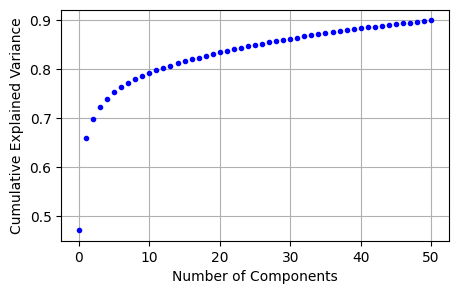

In [103]:
X_train, X_test, y_train, y_test, i_train, i_test= train_test_split(feature_matrix, labels, np.arange(labels.size), test_size= .3, random_state= 0)

scaler= StandardScaler()

pca= PCA()
principal_components= pca.fit_transform(X_train)
var_csum= np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(5,3))
plt.plot(var_csum[var_csum < .9], "b .")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()

required_variance= .6
no_components= sum(pca.explained_variance_ratio_.cumsum() < required_variance) + 1
pca_var= PCA(no_components)

feature_matrix= feature_matrix[labels!= 0]
print(f"Initial features: {feature_matrix.shape[1]} Final components: {no_components}")


### Support Vector Regressor & Hyperparameter Tuning

In [104]:
svr= SVR()
param_grid= [
  {"kernel": ["linear"], "C": [.1, 1, 10, 100]},
  {"kernel": ["rbf"], "C": [1, 10, 100, 1000], "gamma": [1, .1, .01, .001, 0.0001]}
 ]

param_grid= [
  {"kernel": ["rbf"], "C": [100], "gamma": [.01]}
 ]

svr_tuned= GridSearchCV(svr, param_grid= param_grid, verbose= True)
svr_tuned.fit(X_train, y_train)

print(svr_tuned.best_params_)
# print(svr_tuned.cv_results_)

model= Pipeline([
    ("Scaler", scaler),
    ("PCA", pca_var),
    ("SVR", svr_tuned.best_estimator_)
])


Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [105]:
model.fit(X_train, y_train)
y_pred= model.predict(X_test)

mae= mean_absolute_error(y_test, y_pred)
r2= r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error: 11.032
R^2 Score: 0.787


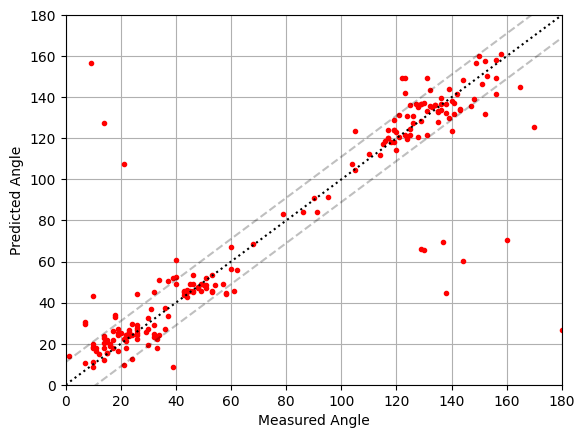

In [106]:
plt.plot(y_test, y_pred, "r.")
plt.plot(np.arange(0, 180), np.arange(0, 180), "k:")
plt.plot(np.arange(0, 180), np.arange(0, 180)-mae, "k--", alpha= .25)
plt.plot(np.arange(0, 180), np.arange(0, 180)+mae, "k--", alpha= .25)
plt.xlabel("Measured Angle")
plt.ylabel("Predicted Angle")
plt.axis([0, 180, 0, 180])
plt.grid()

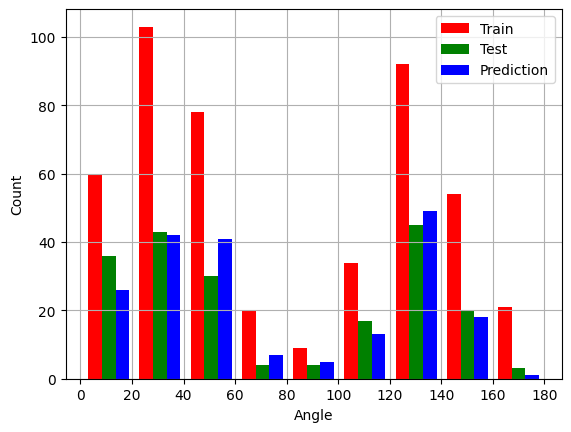

In [107]:
plt.hist([y_train, y_test, y_pred], color= ["r", "g", "b"], bins= 9)
plt.xticks(np.arange(0, 181, 20))
plt.ylabel("Count")
plt.xlabel("Angle")
plt.legend(["Train", "Test", "Prediction"])
plt.grid()


Max error at i_abs= 622, measured: 180, predicted: 26.51, error= 153.49
Max error at i_abs= 641, measured: 9, predicted: 156.61, error= 147.61
Max error at i_abs= 652, measured: 14, predicted: 127.39, error= 113.39
Max error at i_abs= 122, measured: 138, predicted: 44.56, error= 93.44
Max error at i_abs= 524, measured: 160, predicted: 70.27, error= 89.73
Max error at i_abs= 374, measured: 21, predicted: 107.41, error= 86.41


Text(0.5, 0.98, 'Max Errors')

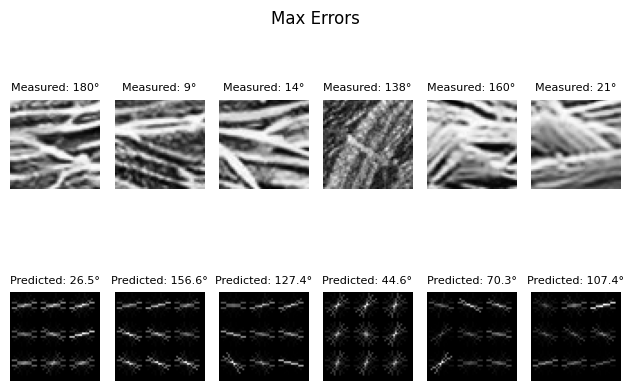

In [108]:
y_error= abs(y_pred-y_test)
y_error_sorted= np.sort(y_error)[::-1]
no_pics= 6

fig, axs = plt.subplots(2, no_pics)

for i in np.arange(0, no_pics):
    i_max_error= np.where(y_error== y_error_sorted[i])[0]
    i_abs= i_test[i_max_error][0]

    print(f"Max error at i_abs= {i_abs}, measured: {y_test[i_max_error][0]}, predicted: {y_pred[i_max_error][0]:.2f}, error= {y_error_sorted[i]:.2f}")

    img_dir= img_directories[i_abs]
    img= get_img(img_dir)

    hog_features, hog_image = hog(img, orientations= 8, pixels_per_cell= (int(img.shape[0]/3), int(img.shape[1]/3)),
                        visualize=True, feature_vector= True)


    plt.subplot(2, no_pics, i+1)
    plt.imshow(img, cmap= "gray")
    #plt.title("Original Image")
    plt.axis("off")
    plt.title(f"Measured: {y_test[i_max_error][0]}{chr(176)}", size= 8)

    plt.subplot(2, no_pics, i+1 + no_pics)
    plt.imshow(hog_image, cmap='gray')
    #plt.title("HOG Image")
    plt.axis("off")
    plt.title(f"Predicted: {y_pred[i_max_error][0]:.1f}{chr(176)}", size= 8)

plt.tight_layout()
plt.suptitle("Max Errors")

Max error at i_abs= 181, measured: 24, predicted: 23.99, error= 0.01
Max error at i_abs= 45, measured: 49, predicted: 48.91, error= 0.09
Max error at i_abs= 92, measured: 46, predicted: 45.83, error= 0.17
Max error at i_abs= 505, measured: 142, predicted: 141.82, error= 0.18
Max error at i_abs= 463, measured: 15, predicted: 15.34, error= 0.34
Max error at i_abs= 478, measured: 118, predicted: 118.35, error= 0.35


Text(0.5, 0.98, 'Min Errors')

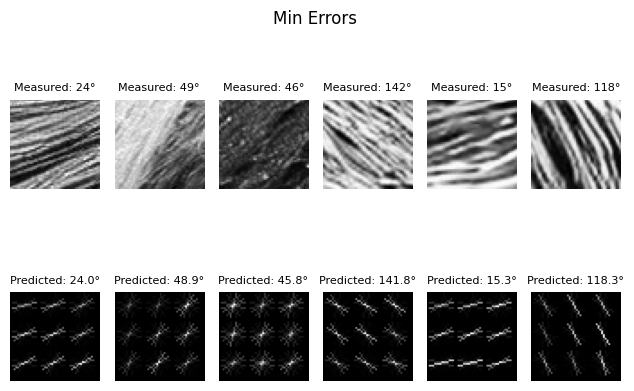

In [109]:
y_error= abs(y_pred-y_test)
y_error_sorted= np.sort(y_error)
no_pics= 6

fig, axs = plt.subplots(2, no_pics)

for i in np.arange(0, no_pics):
    i_max_error= np.where(y_error== y_error_sorted[i])[0]
    i_abs= i_test[i_max_error][0]

    print(f"Max error at i_abs= {i_abs}, measured: {y_test[i_max_error][0]}, predicted: {y_pred[i_max_error][0]:.2f}, error= {y_error_sorted[i]:.2f}")

    img_dir= img_directories[i_abs]
    img= get_img(img_dir)

    hog_features, hog_image = hog(img, orientations= 8, pixels_per_cell= (int(img.shape[0]/3), int(img.shape[1]/3)),
                        visualize=True, feature_vector= True)


    plt.subplot(2, no_pics, i+1)
    plt.imshow(img, cmap= "gray")
    plt.axis("off")
    plt.title(f"Measured: {y_test[i_max_error][0]}{chr(176)}", size= 8)

    plt.subplot(2, no_pics, i+1 + no_pics)
    plt.imshow(hog_image, cmap='gray')
    plt.axis("off")
    plt.title(f"Predicted: {y_pred[i_max_error][0]:.1f}{chr(176)}", size= 8)

plt.tight_layout()
plt.suptitle("Min Errors")

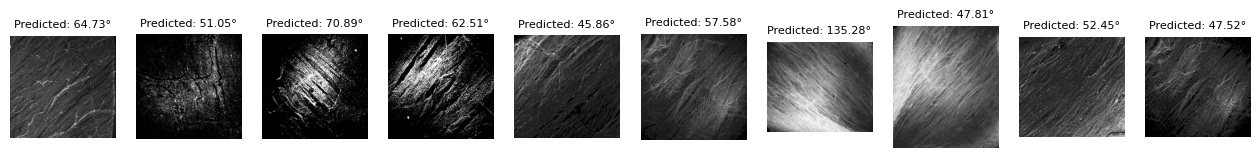

In [110]:
por_feature_matrix= []
por_img_directories= []

for img_dir in os.listdir("./pictures/por_image/"):
    img_dir= "./pictures/por_image/" + img_dir
    img= get_img(img_dir)
    feature_vec= get_feature_vector(img, grid_q= GRIDQ, no_orientation= ORIENTATION)
    por_feature_matrix.append(feature_vec)
    por_img_directories.append(img_dir)

por_feature_matrix= np.array(por_feature_matrix)
por_prediction= model.predict(por_feature_matrix)

fig, axs= plt.subplots(1, len(por_img_directories), figsize= (16, 8))
for i, img_dir in enumerate(por_img_directories):
    img= cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    hog_features, hog_image = hog(img, orientations= 8, pixels_per_cell= (int(img.shape[0]/4), int(img.shape[1]/4)),
                        visualize=True, feature_vector= True)

    plt.subplot(1, len(por_img_directories), i+1)
    plt.imshow(img, cmap= "gray")
    plt.axis("off")
    plt.title(f"Predicted: {por_prediction[i]:.2f}{chr(176)}", size= 8)


Mean Absolute Error: 14.334


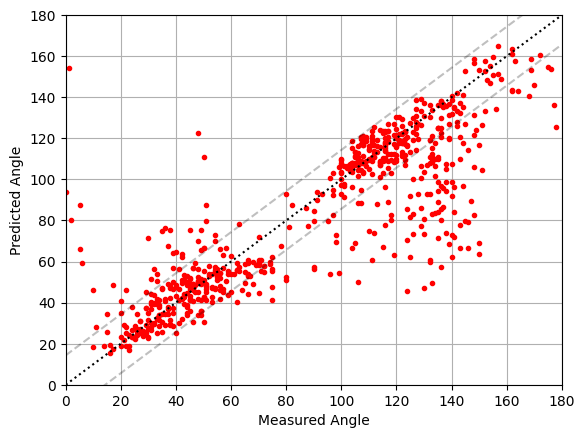

In [111]:
rotated_feature_matrix= []
rotated_labels= [(label + 90) % 180 for label in labels]

for img_dir in img_directories:
    img= get_img(img_dir, rotated= True)
    feature_vec= get_feature_vector(img, grid_q= GRIDQ, no_orientation= ORIENTATION)
    rotated_feature_matrix.append(feature_vec)
    

rotated_feature_matrix= np.array(rotated_feature_matrix)
rotated_prediction= model.predict(rotated_feature_matrix)

rotated_mae= mean_absolute_error(rotated_labels, rotated_prediction)
print(f"Mean Absolute Error: {rotated_mae:.3f}")

plt.figure()
plt.plot(rotated_labels, rotated_prediction, "r.")
plt.plot(np.arange(0, 180), np.arange(0, 180), "k:")
plt.plot(np.arange(0, 180), np.arange(0, 180)-rotated_mae, "k--", alpha= .25)
plt.plot(np.arange(0, 180), np.arange(0, 180)+rotated_mae, "k--", alpha= .25)
plt.xlabel("Measured Angle")
plt.ylabel("Predicted Angle")
plt.axis([0, 180, 0, 180])
plt.grid()


Mean Absolute Error: 9.231


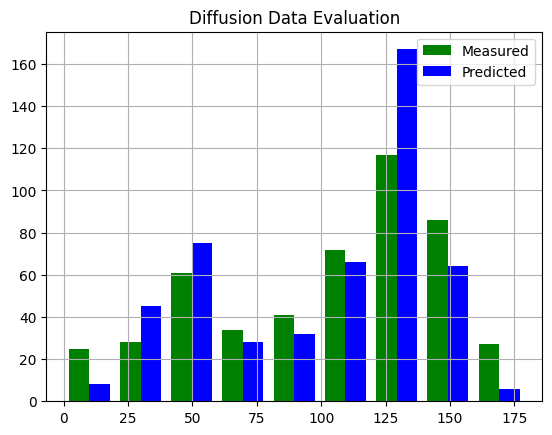

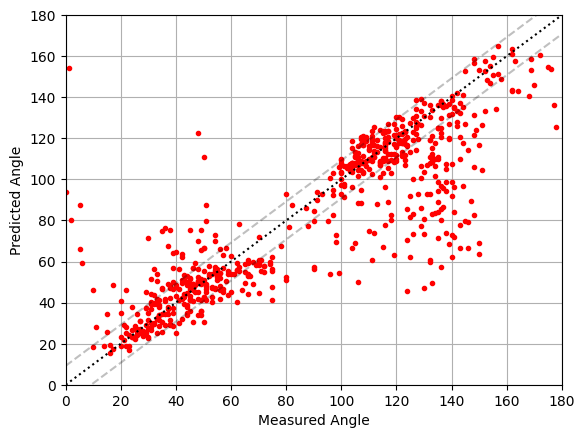

In [114]:
file_dir= "./diffusion/diffusion_voxels/"
csv_dir= "./diffusion/diffusion_voxels/diffusion.csv"
diffusion_csv= np.loadtxt(csv_dir)

diffusion_feature_matrix= []
diffusion_img_directories= []
diffusion_labels= []

for index, label in enumerate(diffusion_csv):
    if not np.isnan(label):
        img_dir= file_dir + str(index+2001) + ".png"
        img= get_img(img_dir)
        feature_vec= get_feature_vector(img, grid_q= GRIDQ, no_orientation= ORIENTATION)
        
        diffusion_feature_matrix.append(feature_vec)
        diffusion_img_directories.append(img_dir)
        diffusion_labels.append(label)

diffusion_feature_matrix= np.array(diffusion_feature_matrix)
diffusion_labels= np.array(diffusion_labels)
diffusion_prediction= model.predict(diffusion_feature_matrix)
mae= mean_absolute_error(diffusion_labels, diffusion_prediction)

print(f"Mean Absolute Error: {mae:.3f}")

plt.hist([diffusion_labels, diffusion_prediction], color= ["g", "b"], bins= 9)
plt.legend(["Measured", "Predicted"])
plt.title("Diffusion Data Evaluation")
plt.grid()

plt.figure()
plt.plot(rotated_labels, rotated_prediction, "r.")
plt.plot(np.arange(0, 180), np.arange(0, 180), "k:")
plt.plot(np.arange(0, 180), np.arange(0, 180)-mae, "k--", alpha= .25)
plt.plot(np.arange(0, 180), np.arange(0, 180)+mae, "k--", alpha= .25)
plt.xlabel("Measured Angle")
plt.ylabel("Predicted Angle")
plt.axis([0, 180, 0, 180])
plt.grid()


In [120]:
print(feature_matrix.shape)
print(labels.shape)
print(diffusion_feature_matrix.shape)
print(diffusion_labels.shape)


(673, 440)
(491, 440)
(491,)
(673,)
